# Tracking an unknown number of objects

While SVI can be used to learn components and assignments of a mixture model, pyro.contrib.tracking provides more efficient inference algorithms to estimate assignments. This notebook demonstrates how to use the `MarginalAssignmentPersistent` with EM.

In [1]:
from __future__ import absolute_import, division, print_function
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.contrib.tracking.hashing import LSH, merge_points
from pyro.ops.newton import newton_step
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam, ASGD, SGD
from pyro.util import warn_if_nan

from datagen_utils import generate_data, get_positions
from plot_utils import plot_solution, plot_exists_prob

%matplotlib notebook
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

## Model
Technically we're not using the model in this version.

In [2]:
@poutine.broadcast
def model(args, observations):
    with pyro.iarange("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                             dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.scale(scale=exists):
            states_loc = pyro.sample("states", dist.Normal(0., 1.).expand([2]).independent(1))
            positions = get_positions(states_loc,args.num_frames)
    with pyro.iarange("detections", observations.shape[1]):
        with pyro.iarange("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            is_observed = (observations[..., -1] > 0)
            with poutine.scale(scale=is_observed.float()):
                assign = pyro.sample("assign",
                                     dist.Categorical(torch.ones(args.max_num_objects + 1)))
            is_spurious = (assign == args.max_num_objects)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)
            # TODO Make these Bernoulli probs more plausible.
            pyro.sample("is_real",
                        dist.Bernoulli(args.expected_num_objects / observations.shape[1]),
                        obs=is_real.float())
            pyro.sample("is_spurious",
                        dist.Bernoulli(args.expected_num_spurious / observations.shape[1]),
                        obs=is_spurious.float())

            # The remaining continuous part is exact.
            observed_positions = observations[..., 0]
            with poutine.scale(scale=is_real.float()):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                predicted_positions = augmented_positions[:, assign]
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale),
                            obs=observed_positions)
            with poutine.scale(scale=is_spurious.float()):
                pyro.sample("spurious_observations", dist.Normal(0., 1.),
                            obs=observed_positions)

In [3]:
def compute_exists_logits(states_loc, replicates):
    FUDGE = -5
    return states_loc.new_empty(states_loc.shape[0]).fill_(-math.log(replicates) + FUDGE)

def compute_assign_logits(positions, observations, replicates, args):
    log_likelihood = detection_log_likelihood(positions, observations, args)
    assign_logits = log_likelihood[...,:-1] - log_likelihood[...,-1:] - math.log(replicates)
    assign_logits[log_likelihood[..., 0] == -float('inf')] = -float('inf')
    return assign_logits

def detection_log_likelihood(positions, observations, args):
    real_dist = dist.Normal(positions.unsqueeze(-2), args.emission_noise_scale)
    spurious_dist = dist.Normal(0., 1.)
    is_observed = (observations[..., -1] > 0)
    observed_positions = observations[..., 0].unsqueeze(-1)
    a=(real_dist.log_prob(observed_positions) +
                 math.log(args.expected_num_objects * args.emission_prob))
    b= (spurious_dist.log_prob(observed_positions) +
                                 math.log(args.expected_num_spurious))
    assign_logits = torch.cat((a,b), dim=-1)
    assign_logits[~is_observed] = -float('inf')
    return assign_logits

## Guide
This guide uses EM.

In [4]:
@poutine.broadcast
def guide(args, observations):
    # Initialize states randomly from the prior.
    states_loc = pyro.param("states_loc", lambda: torch.randn(args.max_num_objects, 2))
    is_observed = (observations[..., -1] > 0)
    
    for em_iter in range(args.em_iters):
        states_loc = states_loc.detach()
        states_loc.requires_grad = True
        positions = get_positions(states_loc,args.num_frames)
        replicates = max(1, states_loc.shape[0]/args.expected_num_objects)
        # E-step: compute soft assignments
        with torch.no_grad():
            assign_logits = compute_assign_logits(positions, observations, replicates, args)
            exists_logits = compute_exists_logits(states_loc, replicates)
            assignment = MarginalAssignmentPersistent(exists_logits, assign_logits,
                                              args.bp_iters, bp_momentum=args.bp_momentum)
            p_exists = assignment.exists_dist.probs
            p_assign = assignment.assign_dist.probs
        
        log_likelihood = detection_log_likelihood(positions,observations, args)
        loss = -(log_likelihood * p_assign).sum()
        states_loc, _ = newton_step(loss, states_loc,
                                    args.emission_noise_scale # TODO: Play with this
                                    )  # M-step
        
        if args.prune_threshold > 0.0:
            states_loc = states_loc[p_exists > args.prune_threshold]
        if args.merge_radius >= 0.0:
            states_loc, _ = merge_points(states_loc, args.merge_radius)
        warn_if_nan(states_loc, 'states_loc')
    
    positions = get_positions(states_loc,args.num_frames)
    replicates = max(1, states_loc.shape[0]/args.expected_num_objects)
    assign_logits = compute_assign_logits(positions, observations, replicates, args)
    exists_logits = compute_exists_logits(states_loc, replicates)
    assignment = MarginalAssignmentPersistent(exists_logits, assign_logits,
                                      args.bp_iters, bp_momentum=args.bp_momentum)

    with pyro.iarange("objects", states_loc.shape[0]):
        exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
        with poutine.scale(scale=exists):
            pyro.sample("states", dist.Delta(states_loc).independent(1))
    with pyro.iarange("detections", observations.shape[1]):
        with poutine.scale(scale=is_observed.float()):
            with pyro.iarange("time", args.num_frames):
                pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

    return assignment, states_loc

## Generate data

We'll define a global config object to make it easy to port code to `argparse`.

In [6]:
args = type('Args', (object,), {})  # A fake ArgumentParser.parse_args() result.
args.num_frames = 40
args.max_num_objects = 400
args.expected_num_objects = 2.
args.expected_num_spurious = 0.2  # If this is too small, BP will be unstable.
args.emission_prob = 0.8          # If this is too large, BP will be unstable.
args.emission_noise_scale = 0.1   # If this is too small, SVI will see flat gradients.
args.bp_iters = 50
args.bp_momentum =0.5
args.em_iters = 10
args.merge_radius = 0.5
args.prune_threshold = 1e-2
assert args.max_num_objects >= args.expected_num_objects

In [7]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_data(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

generated 78 detections from 2 objects


## Evaluate
10 iterations of EM with and without merging

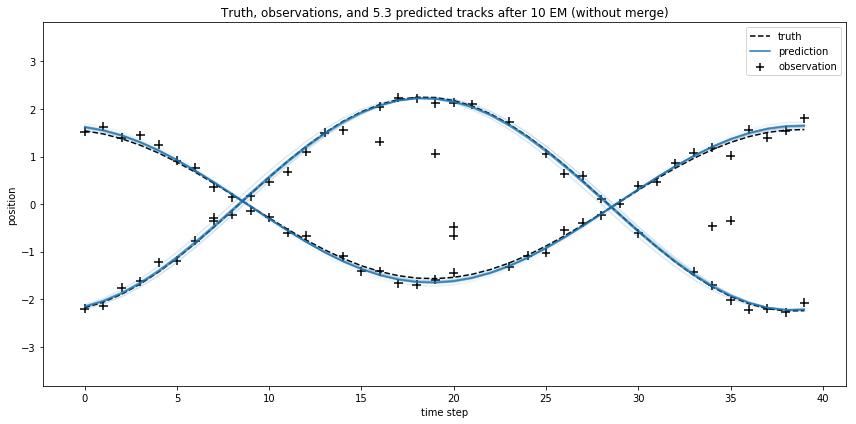

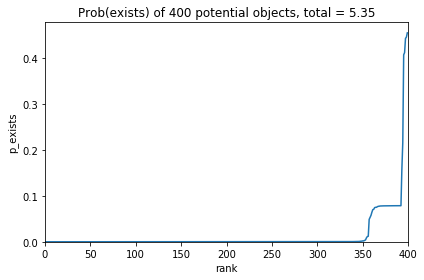

In [8]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
old_merge_radius= args.merge_radius
old_prune_thres= args.prune_threshold
args.merge_radius = -1
args.prune_threshold = -1
pyro.clear_param_store()
assignment, states_loc = guide(args, observations)
p_exists = assignment.exists_dist.probs
positions = get_positions(states_loc, args.num_frames)
plot_solution(observations, p_exists, positions, true_positions, args, 'after 10 EM (without prune or merge)')
plot_exists_prob(p_exists)
args.merge_radius = old_merge_radius
args.prune_threshold = old_prune_thres

In [ ]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
pyro.clear_param_store()
assignment, states_loc = guide(args, observations)
p_exists = assignment.exists_dist.probs
positions = get_positions(states_loc, args.num_frames)
plot_solution(observations, p_exists, positions, true_positions, args, 'after 10 EM (with prune and merge)')
plot_exists_prob(p_exists)